In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
from tqdm import tqdm



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import re

from statsmodels.formula.api import ols
import statsmodels.api as sm
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split
from statsmodels.api import qqplot 
from scipy.stats import shapiro,ttest_ind
from statsmodels.stats.diagnostic import het_breuschpagan,linear_rainbow  
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

In [2]:
data = pd.read_csv('All_data.csv')

In [3]:
grades = pd.read_csv('All_grades.csv')

# Data Cleaning

In [4]:
users = grades.user_id.tolist()

In [5]:
user_id = []
for i in data['Description']:
    try:
        discovered_id = i.split("'")[1].replace('.',"")
        _ = int(discovered_id)
        
        user_id.append(discovered_id)
        
    except:
        user_id.append('error')
 

In [6]:
data['user_id'] = user_id
data_users = data.user_id.unique().tolist()

In [7]:
data_users_int = []
for i in data_users:
    try: 
        data_users_int.append(int(i))
    except: 
        continue

In [8]:
not_students = list(set(data_users_int) - set(users))

In [9]:
not_students.append('error')
not_students = [str(i) for i in not_students]
not_students[:10]

['0', '5120', '2', '5123', '5125', '5130', '7179', '5133', '5135', '2064']

In [10]:
data=data[~data.user_id.isin(not_students)]

In [11]:
data = data.reset_index(drop = True)

# Dictionary

In [12]:
data['Time'] = pd.to_datetime(data['Time'], dayfirst=True)

In [13]:
def extract_date(datetime):
    return datetime.day, datetime.week, datetime.month,datetime.year

data['day'], data['week'], data['month'], data['year'] = zip(*data['Time'].map(extract_date))

data['week'] = data['week'] - (data['week'].min() -1)

In [14]:
interval_def_template = {
       'start_date': '',
       'end_date': '',
       'student_ids' : {}
}

In [15]:
def filter_intervals_data(data, time='week'):

    user_activity_dict = {}

    interval_range = sorted(data[time].unique())
    unique_event_dict = {item : 0 for item in data['Event name'].unique()}

    for interval in tqdm(interval_range):
        interval_def_template = {
           'start_date': '',
           'end_date': '',
           'student_ids' : {}
        }

        dict_template = {}

        filtered_data = data[data[time]==interval]
        int_start, int_end = str(filtered_data.Time.min().date()), str(filtered_data.Time.max().date())

        interval_def_template['start_date'], interval_def_template['end_date'] = int_start, int_end

        for user_id in filtered_data.user_id.unique():
            
            user_filtered_events = filtered_data[filtered_data.user_id==user_id]['Event name'].value_counts()
            dict_template[user_id] = dict(unique_event_dict)

            for event, count in dict(user_filtered_events).items():
                dict_template[user_id][event] = count
            
            dict_template[user_id]['type'] = filtered_data[filtered_data.user_id==user_id]['type'].unique()[0]
            dict_template[user_id]['level'] = filtered_data[filtered_data.user_id==user_id]['level'].unique()[0]

        interval_def_template['student_ids'] = dict_template

        user_activity_dict[f"{time}_{interval}"] = interval_def_template
        
    return user_activity_dict
    


# Dict to Dataframe and Merging with Grades

In [16]:
user_filtered_events = filter_intervals_data(data, time='year')

100%|██████████| 1/1 [00:29<00:00, 29.82s/it]


In [17]:
total_user_activity = []
time_interval_list = []

for time_interval, user_events in user_filtered_events.items():
    total_user_activity.append(
        pd.DataFrame(user_filtered_events[f'{time_interval}']['student_ids'].values(), index=user_filtered_events[f'{time_interval}']['student_ids'].keys()))
    
for time_interval, user_events in user_filtered_events.items():
    time_list = [time_interval for i in range(len(user_filtered_events[time_interval]['student_ids'].keys()))]
    time_interval_list+=time_list

In [18]:
k = pd.concat(total_user_activity).reset_index()

In [19]:
time_interval_df = pd.DataFrame(time_interval_list, columns = ['time_interval'])

In [20]:
final = pd.concat([time_interval_df, k], axis=1)

In [21]:
final.rename(columns={'index': 'user_id'},inplace =True)

In [22]:
final.user_id = final.user_id.astype('int')

In [23]:
final = final.merge(grades, on  = 'user_id',how = 'left')

In [24]:
final.dropna(inplace = True)

In [25]:
final.head()

,time_interval,user_id,The status of the submission has been viewed.,Course module viewed,Feedback viewed,Course viewed,Grade user report viewed,User profile viewed,Course activity completion updated,Course user report viewed,...,Subscription created,Subscription deleted,Group member added,Choice answer deleted,Grade item updated,Recent activity viewed,An online text has been uploaded.,type,level,Grades
0,year_2020,2308,312,869,110,805,89,14,58,0,...,0,0,0,0,0,0,0,Quantitative,undergrad,2.3
1,year_2020,1931,190,608,32,332,7,3,69,208,...,0,0,0,0,0,0,0,Quantitative,undergrad,4.0
2,year_2020,2084,257,416,75,353,2,1,69,36,...,0,0,0,0,0,0,0,Quantitative,undergrad,2.7
3,year_2020,2378,331,725,113,564,39,2,57,1,...,0,0,0,0,0,0,0,Quantitative,undergrad,4.0
4,year_2020,1943,544,1114,179,1890,152,33,85,9,...,0,0,0,0,0,0,0,Quantitative,undergrad,4.0


# Modeling

In [26]:
test = final.copy()

In [27]:
for i in test.columns:
    if sum(test[i].values == 0) > 0.3*len(test):
        test.drop(i,axis=1,inplace = True)

In [28]:
test = test.drop(['time_interval','user_id'], 1)

In [29]:
test.Grades = np.where(test.Grades < 3, 'fail', 'sucess')

In [30]:
X = pd.get_dummies(test.drop('Grades', axis = 1))
Y = test.Grades

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2,random_state = 42)

# Logistic Regression

In [34]:
logit = LogisticRegression(max_iter=1e6).fit(X_train,y_train)

In [35]:
print('Accuracy Logistic Regression Train:',logit.score(X_train,y_train))
print('Accuracy Logistic Regression Test:',logit.score(X_test,y_test))

Accuracy Logistic Regression Train: 0.8131868131868132
Accuracy Logistic Regression Test: 0.8369565217391305


In [36]:
Y0_logit = logit.predict_proba(X_train)[:,1]
Y1_logit = logit.predict_proba(X_test)[:,1]
print("ROC AUC Logistic Regression Train", roc_auc_score(y_train,Y0_logit))
print("ROC AUC Logistic Regression Test", roc_auc_score(y_test,Y1_logit))

ROC AUC Logistic Regression Train 0.8671709480932204
ROC AUC Logistic Regression Test 0.8387464387464387


In [37]:
print("Confusion Matrix Logistic Regression Train:")
print(classification_report(y_train,logit.predict(X_train)))

print("Confusion Matrix Logistic Regression Test:")
print(classification_report(y_test,logit.predict(X_test)))

Confusion Matrix Logistic Regression Train:
              precision    recall  f1-score   support

        fail       0.78      0.66      0.71       128
      sucess       0.83      0.90      0.86       236

    accuracy                           0.81       364
   macro avg       0.80      0.78      0.79       364
weighted avg       0.81      0.81      0.81       364

Confusion Matrix Logistic Regression Test:
              precision    recall  f1-score   support

        fail       0.70      0.78      0.74        27
      sucess       0.90      0.86      0.88        65

    accuracy                           0.84        92
   macro avg       0.80      0.82      0.81        92
weighted avg       0.84      0.84      0.84        92



In [98]:
coefs = pd.DataFrame({'features': X_train.columns, 'coefs' : logit.coef_[0]})

In [99]:
coefs

,features,coefs
0,The status of the submission has been viewed.,-0.003387
1,Course module viewed,-0.003098
2,Feedback viewed,-0.045164
3,Course viewed,0.004076
4,Grade user report viewed,0.006026
5,Course activity completion updated,-0.001584
6,A submission has been submitted.,0.593691
7,Submission created.,0.031902
8,A file has been uploaded.,-0.357806
9,Submission form viewed.,0.017894


# Random Forest Classifier

In [38]:
rf = RandomForestClassifier()

In [39]:
param_grid = {
    'n_estimators': np.arange(100,1000,100),
    'max_features': [.3,.5,.7,9],
    'bootstrap': [False, True],
    'max_depth':np.arange(1,15,1)
}

In [42]:
rf_fit = GridSearchCV(estimator=rf, param_grid=param_grid,
      scoring = 'roc_auc',verbose = 1, n_jobs = -1,cv = 3).fit(X_train,y_train)

Fitting 3 folds for each of 1008 candidates, totalling 3024 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3024 out of 3024 | elapsed:  4.0min finished


In [43]:
best_params = rf_fit.best_params_

In [44]:
best_params

{'bootstrap': True, 'max_depth': 8, 'max_features': 0.5, 'n_estimators': 300}

In [45]:
rf = RandomForestClassifier(n_estimators = best_params['n_estimators'],
                            max_features = best_params['max_features'],
                            bootstrap = best_params['bootstrap'],
                            max_depth = 4).fit(X_train,y_train)

In [46]:
print('Accuracy Train Random Forest:', rf.score(X_train,y_train))
print('Accuracy Test Random Forest:', rf.score(X_test,y_test))

Accuracy Train Random Forest: 0.8324175824175825
Accuracy Test Random Forest: 0.7391304347826086


In [47]:
Y0_rf = rf.predict_proba(X_train)[:,1]
Y1_rf = rf.predict_proba(X_test)[:,1]
print("ROC AUC Train Random Forest:", roc_auc_score(y_train,Y0_logit))
print("ROC AUC Test Random Forest:", roc_auc_score(y_test,Y1_logit))

ROC AUC Train Random Forest: 0.8671709480932204
ROC AUC Test Random Forest: 0.8387464387464387


In [48]:
print("Confusion Matrix Random Forest Train:")
print(classification_report(y_train,rf.predict(X_train)))

print("Confusion Matrix Random Forest Test:")
print(classification_report(y_test,rf.predict(X_test)))

Confusion Matrix Random Forest Train:
              precision    recall  f1-score   support

        fail       0.74      0.80      0.77       128
      sucess       0.89      0.85      0.87       236

    accuracy                           0.83       364
   macro avg       0.81      0.82      0.82       364
weighted avg       0.84      0.83      0.83       364

Confusion Matrix Random Forest Test:
              precision    recall  f1-score   support

        fail       0.55      0.59      0.57        27
      sucess       0.83      0.80      0.81        65

    accuracy                           0.74        92
   macro avg       0.69      0.70      0.69        92
weighted avg       0.75      0.74      0.74        92



In [76]:
from sklearn.tree import export_graphviz

In [89]:
y_train.unique()

array(['sucess', 'fail'], dtype=object)

In [93]:
tree.export_graphviz(rf.estimators_[0],
                     out_file="tree.dot",
                     feature_names = X_train.columns, 
                     class_names=y_train.unique(),
                     filled = True)

In [94]:
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

0

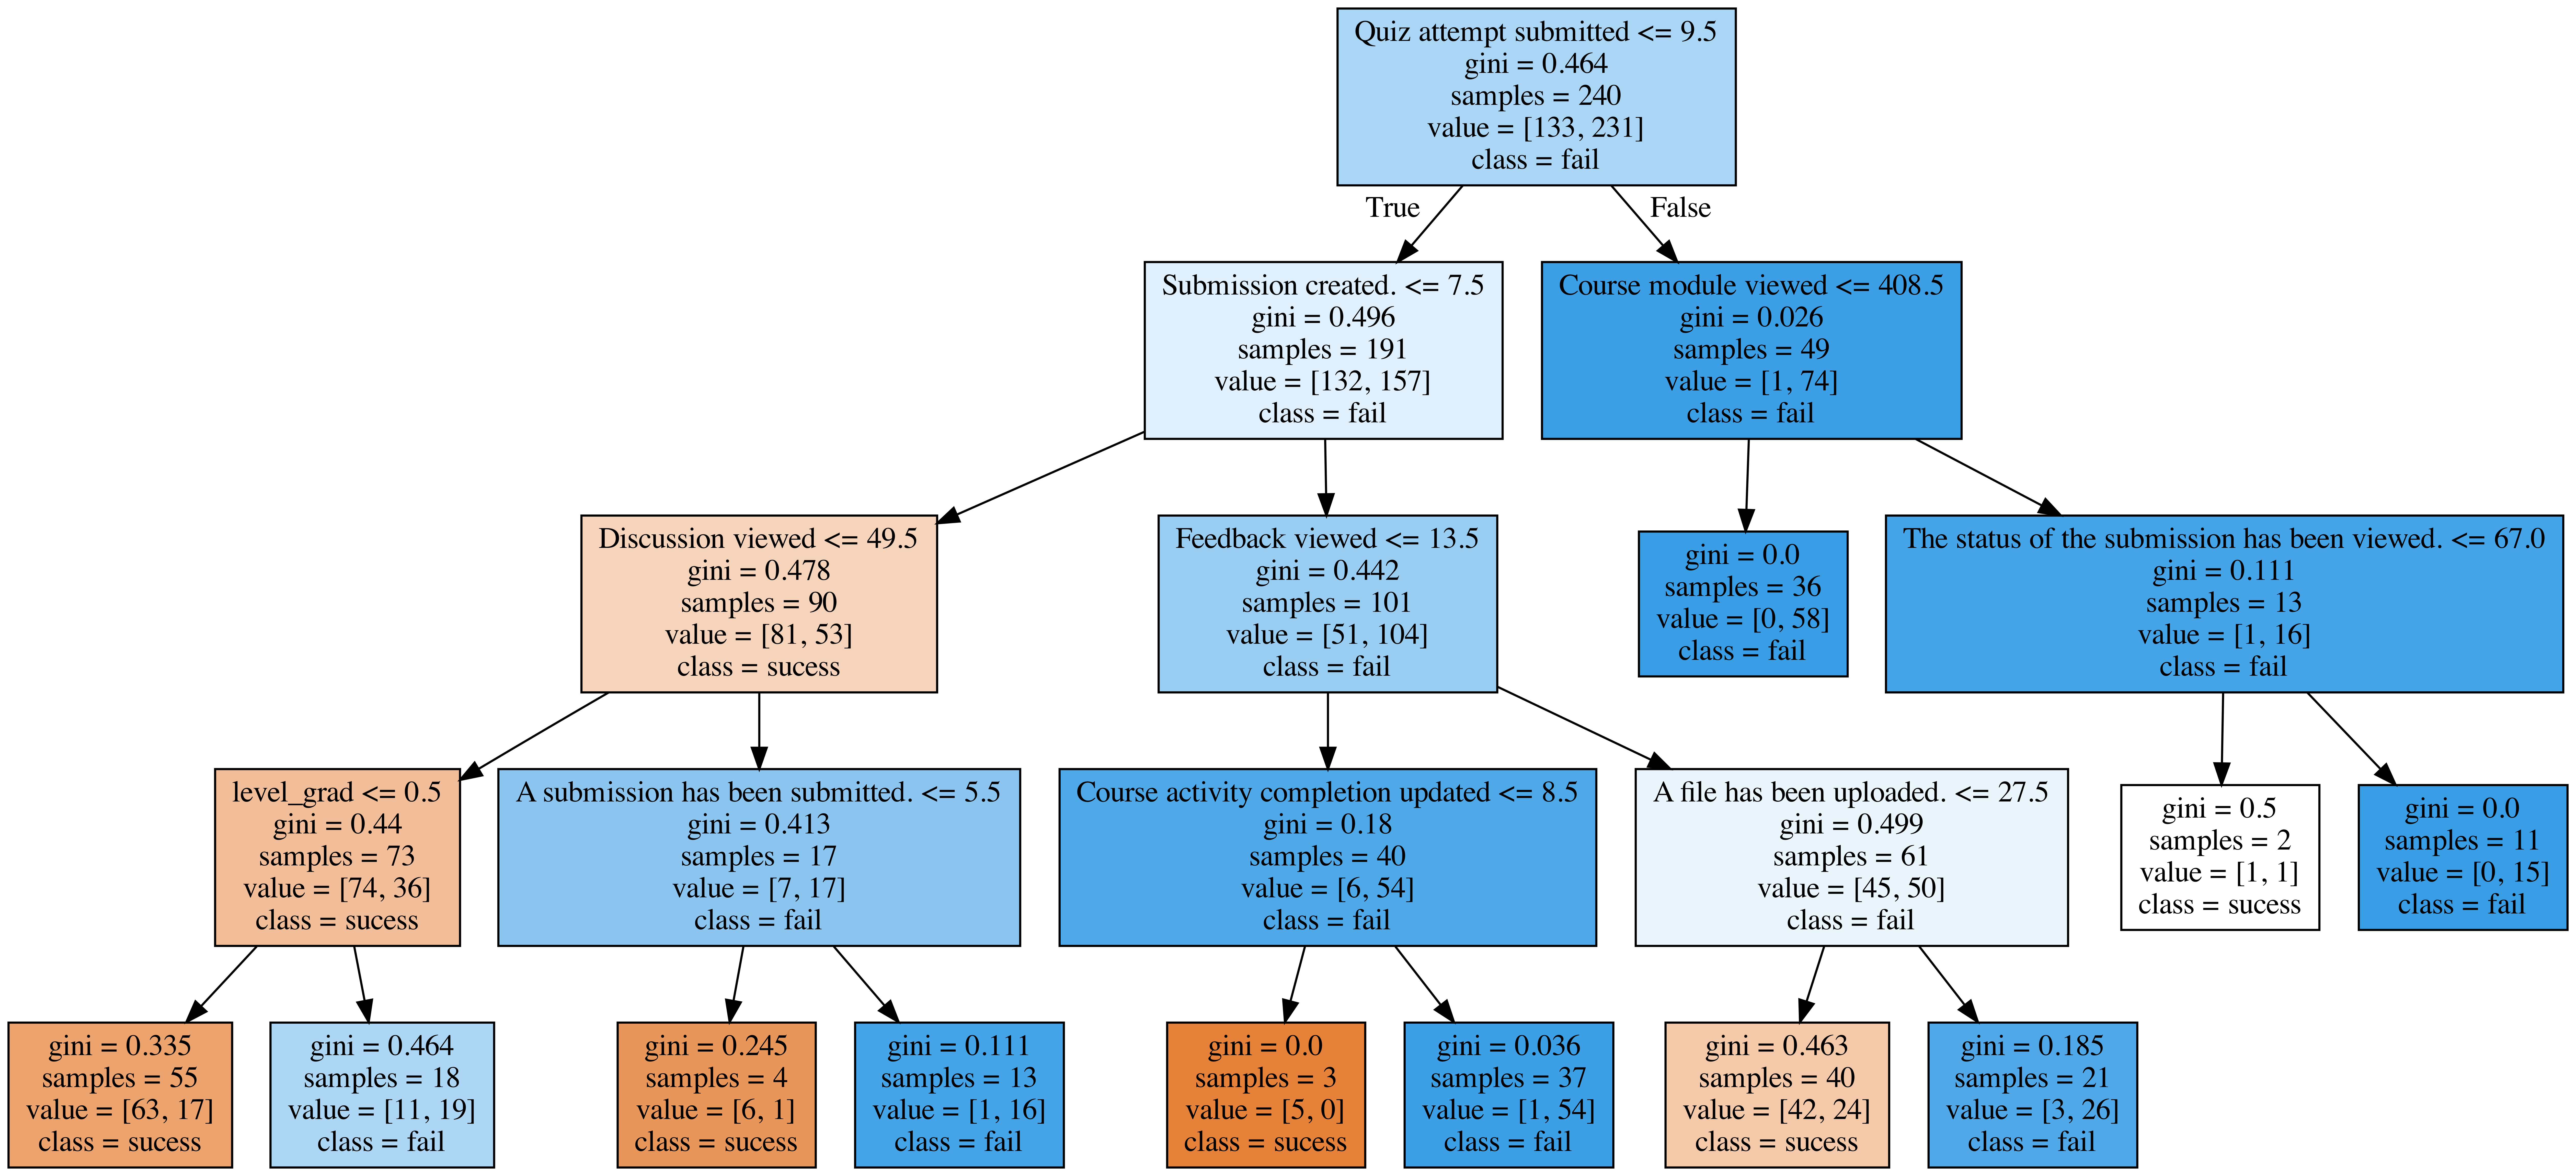

In [97]:
from IPython.display import Image
Image(filename = 'tree.png')

# LightGBM Classifier

In [55]:
param_grid = {
    'num_leaves': np.arange(10,150,10),
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [30, 50, 100, 300, 400],
    'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1],
    'learning_rate' : np.linspace(0.1,0.01,5)
    }

In [56]:
gbm = lgb.LGBMClassifier(boosting_type='gbdt', 
                         objective='binary',
                         num_boost_round=2000, 
                         metric='auc')

In [59]:
gmb_fit = GridSearchCV(estimator=gbm, param_grid=param_grid,
      scoring = 'roc_auc',verbose = 1, n_jobs = -1, cv =3).fit(X_train,y_train)

Fitting 3 folds for each of 4200 candidates, totalling 12600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 579 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:   23.7s
/Users/gevorgatanesyan/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 1922 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 2744 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done 3880 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 5839 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 7875 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 10434 tasks      | elapsed:  

In [61]:
best_params_gbm = gmb_fit.best_params_

In [62]:
best_params_gbm

{'lambda_l1': 1.5,
 'lambda_l2': 0,
 'learning_rate': 0.055,
 'min_data_in_leaf': 30,
 'num_leaves': 10,
 'reg_alpha': 0.1}

In [63]:
gbm = lgb.LGBMClassifier(boosting_type='gbdt', 
                         objective='binary',
                         num_boost_round=2000, 
                         metric='auc',
                         lambda_l1 = best_params_gbm['lambda_l1'],
                         lambda_l2 = best_params_gbm['lambda_l2'],
                         learning_rate= best_params_gbm['learning_rate'],
                         min_data_in_leaf = best_params_gbm['min_data_in_leaf'],
                         num_leaves= best_params_gbm['num_leaves'],
                         reg_alpha= best_params_gbm['reg_alpha']).fit(X_train,y_train)

/Users/gevorgatanesyan/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [64]:
print(gbm.score(X_train,y_train))
print(gbm.score(X_test,y_test))

0.9560439560439561
0.75


In [65]:
Y0_gbm = gbm.predict_proba(X_train)[:,1]
Y1_gbm = gbm.predict_proba(X_test)[:,1]
print("ROC AUC LightGBM Train", roc_auc_score(y_train,Y0_gbm))
print("ROC AUC LightGBM Test", roc_auc_score(y_test,Y1_gbm))

ROC AUC LightGBM Train 0.9931971663135594
ROC AUC LightGBM Test 0.7988603988603988


In [66]:
print("Confusion Matrix LoghtGBM Train:")
print(classification_report(y_train,gbm.predict(X_train)))

print("Confusion Matrix LoghtGBM Test:")
print(classification_report(y_test,gbm.predict(X_test)))

Confusion Matrix LoghtGBM Train:
              precision    recall  f1-score   support

        fail       0.97      0.91      0.94       128
      sucess       0.95      0.98      0.97       236

    accuracy                           0.96       364
   macro avg       0.96      0.94      0.95       364
weighted avg       0.96      0.96      0.96       364

Confusion Matrix LoghtGBM Test:
              precision    recall  f1-score   support

        fail       0.57      0.63      0.60        27
      sucess       0.84      0.80      0.82        65

    accuracy                           0.75        92
   macro avg       0.70      0.71      0.71        92
weighted avg       0.76      0.75      0.75        92



In [101]:
lgb.plot_tree(gbm, figsize=(20,20), dpi=1200)

<AxesSubplot:>

# Multilayer Perceptron

In [110]:
mlp = MLPClassifier(hidden_layer_sizes=16,max_iter=10000).fit(X_train,y_train)

In [112]:
print(mlp.score(X_train,y_train))
print(mlp.score(X_test,y_test))

0.7692307692307693
0.7391304347826086


In [115]:
Y0_mlp = mlp.predict_proba(X_train)[:,1]
Y1_mlp = mlp.predict_proba(X_test)[:,1]
print("ROC AUC train", roc_auc_score(y_train,Y0_mlp))
print("ROC AUC test", roc_auc_score(y_test,Y1_mlp))

ROC AUC train 0.8256918697033898
ROC AUC test 0.7435897435897436


In [116]:
print("MLP Train:")
print(classification_report(y_train,mlp.predict(X_train)))

print("MLP Test:")
print(classification_report(y_test,mlp.predict(X_test)))

MLP Train:
              precision    recall  f1-score   support

        fail       0.78      0.48      0.60       128
      sucess       0.77      0.92      0.84       236

    accuracy                           0.77       364
   macro avg       0.77      0.70      0.72       364
weighted avg       0.77      0.77      0.75       364

MLP Test:
              precision    recall  f1-score   support

        fail       0.59      0.37      0.45        27
      sucess       0.77      0.89      0.83        65

    accuracy                           0.74        92
   macro avg       0.68      0.63      0.64        92
weighted avg       0.72      0.74      0.72        92



In [117]:
def run_models(model_obj, model_name, model_param_dict, X_train,y_train):
    mdl = model_obj(**model_param_dict[model_name]).fit(X_train,y_train)
    
    train_score = mdl.score(X_train,y_train)
    test_score = mdl.score(X_test,y_test)
    
    Y0_mdl = logit.predict_proba(X_train)[:,1]
    Y1_mdl = logit.predict_proba(X_test)[:,1]
    roc_auc_0, roc_auc_1 = roc_auc_score(y_train,Y0_mdl), roc_auc_score(y_test,Y1_mdl)
    
    class_report_train = classification_report(y_train,mdl.predict(X_train))
    class_report_test = classification_report(y_test,mdl.predict(X_test))
    
    print(f'{model_name} Performance \n')
    print('Train Score', train_score)
    print('Test Score', test_score)
    print(class_report_train)
    print(class_report_test)
    
    


In [118]:
rf.base_estimator

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [598]:
model_param_dict  = {
    'MLPClassifier': {
        'hidden_layer_sizes': 16,
        'max_iter': 10000
    },
    'LogisticRegression': {
        'max_iter': 1e6
    },
    'LGBMClassifier': {
        "boosting_type":'gbdt', 
         "objective": 'binary',
         "num_boost_round":2000, 
         "metric": 'auc',
         "lambda_l1" : 0.1,
         "lambda_l2" : 0.1,
         "learning_rate":0.01,
         "min_data_in_leaf" : 140,
         "num_leaves":10,
         "reg_alpha":0.1
    },
    'RandomForestClassifier': {
        'bootstrap': True, 
        'max_depth': 4, 
        'max_features': 0.3, 
        'n_estimators': 100
    }
    
}

In [599]:
from lightgbm import LGBMClassifier

In [601]:
run_models(RandomForestClassifier, 'RandomForestClassifier', model_param_dict, X_train,y_train)

RandomForestClassifier Performance 

Train Score 0.8241758241758241
Test Score 0.7934782608695652
              precision    recall  f1-score   support

        fail       0.77      0.69      0.73       125
      sucess       0.85      0.90      0.87       239

    accuracy                           0.82       364
   macro avg       0.81      0.79      0.80       364
weighted avg       0.82      0.82      0.82       364

              precision    recall  f1-score   support

        fail       0.72      0.60      0.65        30
      sucess       0.82      0.89      0.85        62

    accuracy                           0.79        92
   macro avg       0.77      0.74      0.75        92
weighted avg       0.79      0.79      0.79        92



# Kmeans

In [649]:
plot = final.copy()

In [ ]:
plot.columns

In [656]:
plot.select_dtypes(exclude = 'object').columns

Index(['user_id', 'The status of the submission has been viewed.',
       'Course module viewed', 'Feedback viewed', 'Course viewed',
       'Grade user report viewed', 'User profile viewed',
       'Course activity completion updated', 'Course user report viewed',
       'Zip archive of folder downloaded', 'A submission has been submitted.',
       'Submission created.', 'A file has been uploaded.',
       'Submission form viewed.', 'Grade overview report viewed',
       'Comment created', 'User list viewed', 'Discussion viewed',
       'Submission updated.', 'The status of the submission has been updated.',
       'Remove submission confirmation viewed.', 'Badge listing viewed',
       'User report viewed', 'Course module instance list viewed',
       'Role assigned', 'User enrolled in course',
       'User unenrolled from course', 'Role unassigned', 'Course searched',
       'Comment deleted', 'Quiz attempt reviewed', 'Quiz attempt submitted',
       'Quiz attempt viewed', 'User gra

In [660]:
# for i in plot.select_dtypes(exclude = 'object').columns:
#     plt.title(i)
#     plt.scatter(plot['Grades'], plot[i])
#     plt.show()
